# Bin Buddies 

### COSC 325 Introduction to Machine Learning
#### Group 15
#### Mia Patrikios, Yves Song, Hezekiah McDonald, Isaiah Weaver, Nia Maheshwari
---

**Cleaning Dataset - Yves Song**

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import hashlib, os
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import kagglehub

# Download latest version
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")
rgb_path = "cleaned/garbage-dataset-rgb"
print("Path to dataset files:", path)

hashes = {}
duplicates = []

def file_hash(filePath):
    with open(filePath, "rb") as f: # Open and read files for hashing
        file_bytes = f.read()
        return hashlib.md5(file_bytes).hexdigest()

for root, dirs, files in os.walk(path):
    for file in files:
        file_path = os.path.join(root, file)
        h = file_hash(file_path)

        if h in hashes:
            print(f"Duplicate found! Removing {file_path} (same as {hashes[h]})")
            os.remove(file_path)
            duplicates.append((file_path, hashes[h]))
        else:
            hashes[h] = file_path
            try:
                # Preserve the dataset’s subfolder structure
                rel_dir = os.path.relpath(root, path)
                save_dir = os.path.join(rgb_path, rel_dir)
                os.makedirs(save_dir, exist_ok=True)

                save_path = os.path.join(save_dir, file)

                # Skip non-image files (like metadata.csv)
                if not file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
                    continue

                with Image.open(file_path) as img:
                    img.convert("RGB").save(save_path)

            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                        
                    


Path to dataset files: C:\Users\Foces\.cache\kagglehub\datasets\zlatan599\garbage-dataset-classification\versions\5


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision.transforms as transforms #missing run pip install torchvision

# processing images with tensorflow 
# run 'pip install tensorflow' if module not found



from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import zipfile
from tqdm import tqdm

# Random generator
rng1 = np.random.RandomState(seed=123)

**Data Augmentation - Hezekiah McDonald**

In [ ]:
cleaned_imgs_path = "cleaned\\garbage-dataset-rgb\\Garbage_Dataset_Classification\\images"

#Hello world

#Data Augmentation Function
#Randomly generates a new augmented image with the same name as the OG image but ending with _A
def RandAugment(inpt_img:Image.Image, cur_folder:str, out_name:str):

    augment_select = rng1.random_integers(0,5)
    
    match augment_select:

        case 0:
            new_img = inpt_img.transform(Image.Transpose.ROTATE_90)
        case 1:
            new_img = inpt_img.transpose(Image.Transpose.ROTATE_180)
        case 2:
            new_img = inpt_img.transpose(Image.Transpose.ROTATE_270)
        case 3:
            new_img = inpt_img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        case 4:
            new_img = inpt_img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
        case 5:
            rand_bright = rng1.random_integers(0,100) / 100
            rand_contrast = rng1.random_integers(0,100) / 100
            rand_staturation = rng1.random_integers(0,100) / 100
            rand_hue = rng1.random_integers(0,50) / 100

            color_jitter = transforms.ColorJitter(brightness=rand_bright, contrast=rand_contrast, saturation=rand_staturation, hue=rand_hue)
            
            new_img = color_jitter(inpt_img)
        case _:
            print("Something went wrong")
            
    output_path = os.path.join(cleaned_imgs_path, cur_folder)

    newName = os.path.join(output_path, out_name)

    new_img.save(newName)

#Cleaned Image iterating
for folder in os.listdir(cleaned_imgs_path):

    cur_folder_path = os.path.join(cleaned_imgs_path, folder)

    iter = 0

    #Augments every other image in dataset
    for file in os.listdir(cur_folder_path):

        if iter == 0:

            file_name, file_extension = file.split('.')
            cur_file_path = os.path.join(cur_folder_path, file)

            new_name = file_name + "_A." + file_extension 
       
            img = Image.open(cur_file_path)
            RandAugment(img, folder,new_name)

        iter = (iter + 1) % 2



C:\Users\Foces\AppData\Local\Temp\ipykernel_39408\284653211.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 5 + 1) instead
  augment_select = rng1.random_integers(0,5)


### Data Preprocessing Pipeline


## Feature Extraction - Mia

In [7]:
# Mia - Feature Extraction
%pip install scikit-image
import os
from PIL import Image
from skimage.color import rgb2gray, rgb2hsv
from skimage.feature import local_binary_pattern
from skimage.measure import moments_hu
# Use the cleaned RGB images                                                                                                                                                                                                                                     
path = "cleaned/garbage-dataset-rgb"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
# Check if cleaned images exist                                                                                                                                                                                                                                   
if not os.path.exists(path):                                                                                                                                                                                                                                                                                                                                                                                                                                            
    print("ERROR: Please run the RGB extraction code first (previous cell)")   

def extract_features(img):
    
    # Ensure image is a NumPy array (shape: H × W × 3)
    if isinstance(img, Image.Image):
        img = np.array(img)
        
    # Colors (hsv histogram)
    
    # hsv (hue, saturation, value), the histogram creates a 3D histogram with 8 bins for each section
    hsv = rgb2hsv(img)  
    # create a 3D histogram with 8 bins for each channel
    hist, _ = np.histogramdd(
        hsv.reshape(-1, 3),
        bins=(8, 8, 8),
        range=((0, 1), (0, 1), (0, 1))
    )
    # flatten the histogram to a 512-length vector and normalize it
    color_features = hist.flatten() / (hist.sum() + 1e-6)
    
    # Textures (local binary pattern)
    
    # color is not relevant for texture, so convert to grayscale
    gray = rgb2gray(img)
    # lbp is a texture descriptor that compares each pixel to its neighbors
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    # create a histogram of the lbp values and normalize it
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 60), range=(0, 59))
    lbp_features = lbp_hist / (lbp_hist.sum() + 1e-6)
    
    # Shapes (hu moments)
    
    # convert gray images to 8-bit range for shape features
    gray_255 = (gray * 255).astype(np.uint8)
    # hu moments are shape descriptors that are not affected by scale, rotation, or translation
    hu = moments_hu(gray_255)
    # apply log transform to hu moments to reduce large ranges of numbers
    shape_features = np.log10(np.abs(hu) + 1e-6)
    
    # combine features into a single vector
    return np.concatenate([color_features, lbp_features, shape_features])

features_data = []

# loop thorugh all cleaned images in the dataset
for root, _, files in os.walk(path):
    label = os.path.basename(root)  # target names 
    for file in files:
        print(f"Processing {file}...")
        file_path = os.path.join(root, file)
        try:
            with Image.open(file_path) as img:
                img = img.convert("RGB")
                features = extract_features(img)
                features_data.append([file_path, label] + features.tolist())
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# save to csv file
columns = ["file_path", "label"] + [f"f{i}" for i in range(len(features_data[0]) - 2)]
df = pd.DataFrame(features_data, columns=columns)
df.to_csv("features.csv", index=False)
    

Note: you may need to restart the kernel to use updated packages.
Processing cardboard_00001.jpg...
Processing cardboard_00002.jpg...
Processing cardboard_00003.jpg...
Processing cardboard_00007.jpg...
Processing cardboard_00010.jpg...
Processing cardboard_00012.jpg...
Processing cardboard_00013.jpg...
Processing cardboard_00014.jpg...
Processing cardboard_00015.jpg...
Processing cardboard_00016.jpg...
Processing cardboard_00018.jpg...
Processing cardboard_00020.jpg...
Processing cardboard_00023.jpg...
Processing cardboard_00024.jpg...
Processing cardboard_00025.jpg...
Processing cardboard_00031.jpg...
Processing cardboard_00033.jpg...
Processing cardboard_00034.jpg...
Processing cardboard_00045.jpg...
Processing cardboard_00049.jpg...
Processing cardboard_00054.jpg...
Processing cardboard_00057.jpg...
Processing cardboard_00058.jpg...
Processing cardboard_00069.jpg...
Processing cardboard_00070.jpg...
Processing cardboard_00071.jpg...
Processing cardboard_00072.jpg...
Processing cardb

* Resize images to make them all have the same shape (e.g., 128x128x3 or 224x224x3).
* Normalize pixel values by scaling pixel intensities (from [0,255] to [0,1] or [-1,1], for example)
* Data augmentation (optional) such as random rotations, flips, zooms, brightness shifts to improve generalization.
* batching samples by converting dataset into batches for training

In [8]:
# import os
# import pandas as pd
# import numpy as np

# path = "../input/garbage-dataset-classification/Garbage_Dataset_Classification/images"

# rows = []
# for root, dirs, files in os.walk(path):
#     label = os.path.basename(root)
#     for file in files:
#         if file.lower().endswith((".jpg", ".jpeg", ".png")):
#             # Add 5 random numeric features for testing downstream logic
#             rows.append({
#                 "file_path": os.path.join(root, file),
#                 "label": label,
#                 "f1": np.random.random(),
#                 "f2": np.random.random(),
#                 "f3": np.random.random(),
#                 "f4": np.random.random(),
#                 "f5": np.random.random()
#             })

# df = pd.DataFrame(rows)
# df.to_csv("features.csv", index=False)
# print(f"Created placeholder features.csv with {len(df)} entries and {df.shape[1]-2} features.")


## One-Hot-Encode Data - Nia

In [9]:
df

,file_path,label,f0,f1,f2,f3,f4,f5,f6,f7,...,f568,f569,f570,f571,f572,f573,f574,f575,f576,f577
0,cleaned/garbage-dataset-rgb\Garbage_Dataset_Cl...,cardboard,0.000000,0.000320,0.000702,0.000549,0.000381,0.000687,0.001480,0.000198,...,0.0,0.0,0.0,2.563481,5.117430,5.416048,5.430365,10.853566,7.989054,8.586308
1,cleaned/garbage-dataset-rgb\Garbage_Dataset_Cl...,cardboard,0.000000,0.000000,0.000000,0.000000,0.000153,0.001312,0.079025,0.282288,...,0.0,0.0,0.0,2.401401,4.809694,5.103858,5.096910,10.197281,7.501744,8.096910
2,cleaned/garbage-dataset-rgb\Garbage_Dataset_Cl...,cardboard,0.000000,0.000000,0.000000,0.000000,0.000031,0.000351,0.001144,0.221100,...,0.0,0.0,0.0,2.707570,5.415140,5.716170,5.716170,11.432341,8.423741,-6.000000
3,cleaned/garbage-dataset-rgb\Garbage_Dataset_Cl...,cardboard,0.000000,0.000931,0.000473,0.000366,0.000763,0.000916,0.000214,0.000259,...,0.0,0.0,0.0,2.608526,5.221487,5.513070,5.510568,11.022321,8.121279,9.260733
4,cleaned/garbage-dataset-rgb\Garbage_Dataset_Cl...,cardboard,0.004410,0.009567,0.001785,0.000885,0.000717,0.016357,0.062744,0.037201,...,0.0,0.0,0.0,2.678518,5.358858,5.660794,5.658977,11.318862,8.338406,8.640343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11652,cleaned/garbage-dataset-rgb\Garbage_Dataset_Cl...,trash,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015,0.006729,0.279480,...,0.0,0.0,0.0,2.707570,5.415140,5.716170,5.716170,11.432341,8.423741,-6.000000
11653,cleaned/garbage-dataset-rgb\Garbage_Dataset_Cl...,trash,0.000000,0.000076,0.000351,0.001709,0.001144,0.000488,0.000153,0.000351,...,0.0,0.0,0.0,2.176091,4.409324,4.754234,4.662238,9.368862,6.866881,8.305018
11654,cleaned/garbage-dataset-rgb\Garbage_Dataset_Cl...,trash,0.001129,0.004684,0.002472,0.003036,0.005829,0.016296,0.018188,0.012405,...,0.0,0.0,0.0,1.875061,3.828209,4.127137,4.252197,8.419256,6.164561,7.939421
11655,cleaned/garbage-dataset-rgb\Garbage_Dataset_Cl...,trash,0.001495,0.070038,0.041458,0.019104,0.012619,0.010956,0.011185,0.024857,...,0.0,0.0,0.0,2.705008,5.408316,5.740853,5.681296,11.390285,8.384140,10.382578


In [10]:
# one-hot encode function - this may not be necessary right now, as the features have numerical values
# still including it just in case

# get all the unique possible values in a column to encode (we will create a new column for all unique vals - 1)
# go through every row and see if the value of that category is that column name (add 1)
def PandasOneHotEncodeNumpy(DataFrame, Columns):
    names = []
    for col in Columns:
        features = []
        features = DataFrame[col].unique()
        features = features[:-1]
        
        for feat in features:
            DataFrame[feat] = DataFrame[col].apply(lambda x: 1 if x==feat else 0)
            names.append(feat)
    DataFrame = DataFrame.drop(columns=Columns)
    return DataFrame,names 

### Normalize Data & Remove Colinear Features  - Isaiah Weaver

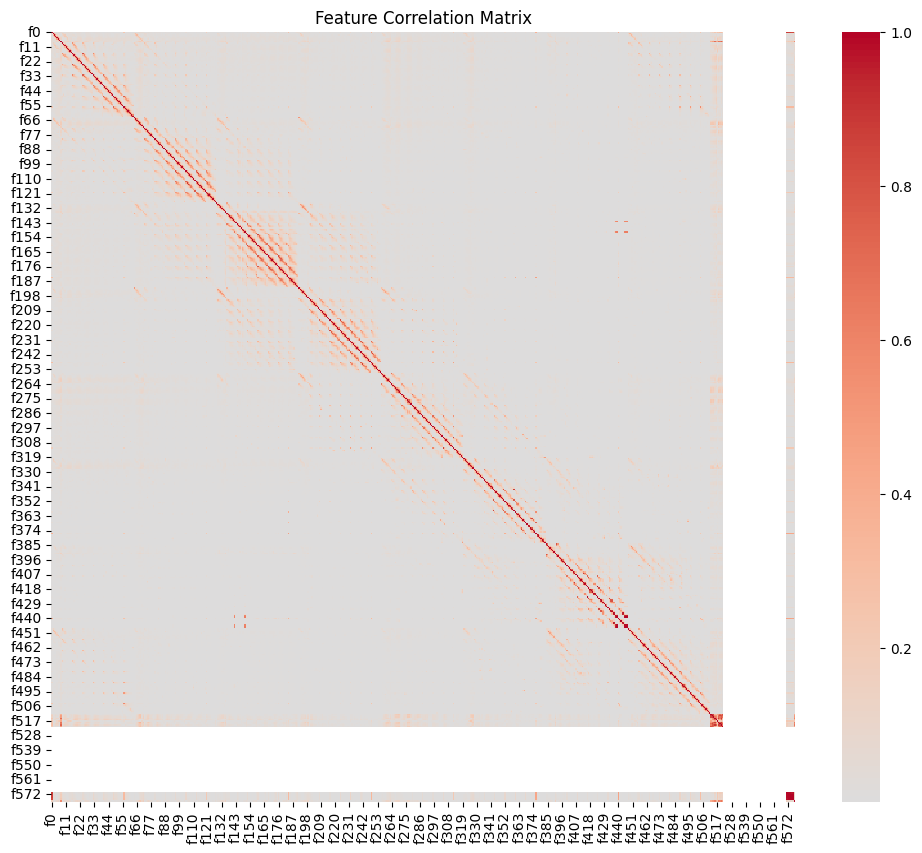

Dropping 14 highly collinear features: ['f422', 'f424', 'f437', 'f439', 'f443', 'f444', 'f445', 'f446', 'f447', 'f572', 'f573', 'f574', 'f575', 'f576']
Final dataset has 564 features (down from 578)


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("features.csv")

# Separate features and labels
feature_cols = [c for c in df.columns if c not in ["file_path", "label"]]
X = df[feature_cols]
y = df["label"]
file_paths = df["file_path"]

# Normalize features between 1 and 0
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Compute correlation matrix
corr_matrix = X_scaled.corr().abs()

# Visualize 
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

# Identify and drop highly collinear features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
threshold = 0.9
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
print(f"Dropping {len(to_drop)} highly collinear features:", to_drop)

X_reduced = X_scaled.drop(columns=to_drop)

# re-Combine with labels and file paths
df_clean = pd.concat([file_paths, y, X_reduced], axis=1)

# Save cleaned CSV
df_clean.to_csv("features_clean.csv", index=False)
print(f"Final dataset has {X_reduced.shape[1]} features (down from {len(feature_cols)})")


# **Visualize Model Performance – Yves Song**

Validation Accuracy: 0.571


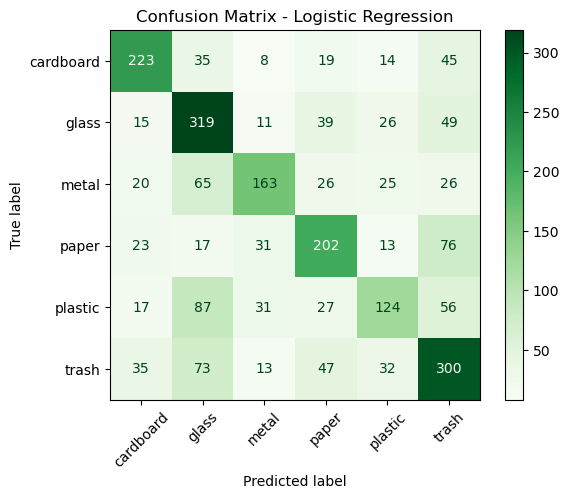

/var/folders/v9/1w1yw15d14d35xlpvslb973m0000gn/T/ipykernel_12844/1369111418.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance[top_idx], y=features[top_idx], palette="mako")


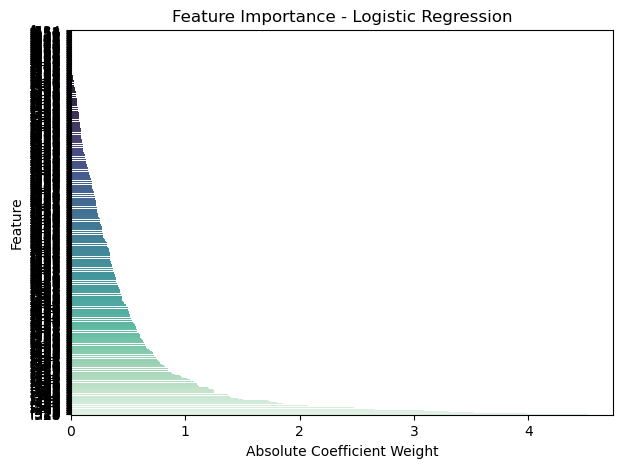

/var/folders/v9/1w1yw15d14d35xlpvslb973m0000gn/T/ipykernel_12844/1369111418.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Logistic Regression"], y=[acc], palette="viridis")


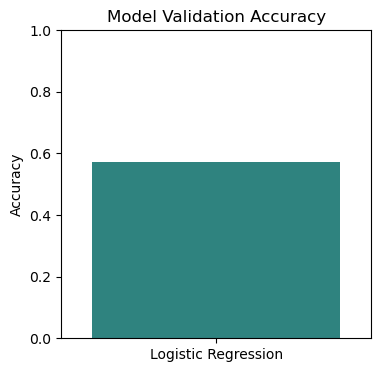

In [8]:
# === Import libraries ===
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# === Load cleaned data ===
df = pd.read_csv("features_clean.csv")

# Separate features & labels
X = df.drop(columns=["file_path", "label"])
y = df["label"]

# Split 80/20 for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Train baseline Logistic Regression model ===
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions + accuracy
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.3f}")

# === Confusion Matrix Plot ===
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Greens", xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# === Feature Importance Plot (Top 5, since we only have 5 features) ===
importance = abs(model.coef_[0])
features = X.columns
top_idx = importance.argsort()[-len(features):]

plt.figure(figsize=(7,5))
sns.barplot(x=importance[top_idx], y=features[top_idx], palette="mako")
plt.title("Feature Importance - Logistic Regression")
plt.xlabel("Absolute Coefficient Weight")
plt.ylabel("Feature")
plt.show()

# === Model Accuracy Summary ===
plt.figure(figsize=(4,4))
sns.barplot(x=["Logistic Regression"], y=[acc], palette="viridis")
plt.title("Model Validation Accuracy")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.show()
